In [151]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
from transformers import pipeline, AutoTokenizer
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Carregando os dados e ordenando-os

In [85]:
file_name = 'data.pkl'

# Carregar o DataFrame usando pickle
with open(file_name, 'rb') as file:
    df = pickle.load(file)

# Ordenar o dataset de acordo com a temporada e episódio em ordem cronológica
df = df.sort_values(by=['season_number', 'episode_number'])
df.head(5)

,title,season_number,episode_number,text,directors,writers
177,Prisoners of Love,1,3,"[{'origin': 'action', 'text': '[The episode st...","[Larry Leichliter, Patrick McHale]","[Pendleton Ward, Adam Muto]"
185,Ricardio the Heart Guy,1,7,"[{'origin': 'action', 'text': '[The episode be...","[Larry Leichliter, Patrick McHale]","[Bert Youn, Sean Jimenez]"
34,Business Time,1,8,"[{'origin': 'action', 'text': '[The episode be...","[Larry Leichliter, Patrick McHale]","[Luther McLaurin, Armen Mirzaian]"
155,My Two Favorite People,1,9,"[{'origin': 'action', 'text': '[Finn and Jake ...","[Larry Leichliter, Patrick McHale]","[Pendleton Ward, Kent Osborne]"
148,Memories of Boom Boom Mountain,1,10,"[{'origin': 'action', 'text': '[The episode st...","[Larry Leichliter, Patrick McHale]","[Bert Youn, Sean Jimenez]"


In [86]:
unique_origins = np.unique(np.concatenate(df['text'].apply(lambda lst: [d['origin'] for d in lst])))

In [87]:
characters_to_drop = ["Pan", "Both", "Banana Guard", "Guards", "Candy Person", "Man", "Tim", "Episode ends", "Crowd", "Candy People", "Rat", "Everyone", "Voice", "Dog", "Banana Guards", "Mom", "Ghost", "Gumball Guardian", "Finn and Jake", "Chips", "Finn & Jake", "All", "Woman", "Alien", "Princess"]
unique_origins = [char for char in unique_origins if char not in characters_to_drop]
len(unique_origins)

1052

In [88]:
def get_character_text(character, dataframe):
    text = []
    for i in range(len(dataframe)):
        episode_text = get_character_episode_text(character, dataframe.iloc[i])
        text += episode_text
    return text

def get_character_episode_text(character, episode):
    episode_text = []
    for line in episode['text']:
        if character in line['origin']:
            episode_text.append(line['text'].strip())
    return episode_text

def make_characters_text_dataframe(characters, dataframe):
    texts_dict = {"character": [], "text":[]}
    for char in characters:
        text = get_character_text(char, dataframe)
        texts_dict['character'].append(char)
        texts_dict['text'].append(text)

    return pd.DataFrame(texts_dict)

characters_df = make_characters_text_dataframe(unique_origins, df)
characters_df.sample(3)

,character,text
974,Tree Trunks,"[[She appears from a corridor, hovering, pale ..."
937,The episode ends.,[]
93,Blonde witch,[The fruuuuit...]


In [89]:
characters_df['lines_amt'] = characters_df['text'].apply(len)
characters_df.sample(3)

,character,text,lines_amt
774,Primo,"[Hyperion, I'm sorry!, Hyperion, my love!]",2
444,Gumball Guardian #1,"[Ugh! My balance!, [Groans] Sorry, mom... [His...",2
277,Eberhardt,"[Huh?, [Scared] Haah!, Please, human boy! Let ...",5


In [91]:
characters_df = characters_df[characters_df['lines_amt'] >= 10]

In [107]:
model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis", model=model_name, tokenizer=tokenizer)

In [93]:
def truncate_and_predict(text, max_tokens=500):
    tokens = tokenizer.encode(text, max_length=max_tokens, truncation=True)
    truncated_text = tokenizer.decode(tokens[1:])
    result = classifier(truncated_text)
    return result

def analyze(character_lines):
    sentiments = []
    for line in character_lines:
        sentiments.append(truncate_and_predict(line))
    return sentiments

characters_df['sentiments'] = characters_df['text'].apply(analyze)
characters_df.sample(3)



,character,text,lines_amt,log_lines_amt,sentiments
210,Colonel Candy Corn,[[Chuckles] That's quite alright. Just don't l...,14,2.708050,"[[{'label': 'caring', 'score': 0.5014061331748..."
837,Rose,"[Marceline! I love, I love., There you are, Fi...",15,2.772589,"[[{'label': 'love', 'score': 0.958978414535522..."
969,Trami,"[[Muffled by the distance] Got it?, I push you...",11,2.484907,"[[{'label': 'neutral', 'score': 0.595468103885..."


In [94]:
labels = list(classifier.model.config.id2label.values())
labels.remove('neutral')

In [95]:
def clean_sentiments(sentiments):
    sents = []
    for sentiment in sentiments:
        sents.append(sentiment[0]['label'])
    return sents

characters_df['sentiments'] = characters_df['sentiments'].apply(clean_sentiments)


In [96]:
for label in labels:
    count_label = lambda label_list: sum(1 for item in label_list if item == label)
    characters_df[label] = characters_df['sentiments'].apply(count_label)

characters_df.sample(3)

,character,text,lines_amt,log_lines_amt,sentiments,admiration,amusement,anger,annoyance,approval,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
530,Jay,"[[scratches chin] Okay, show 'em the apples, S...",19,2.995732,"[neutral, neutral, neutral, neutral, neutral, ...",0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
226,Crunchy,"[[flies out of prize ball] Oh, what time is it...",12,2.564949,"[curiosity, neutral, disapproval, neutral, neu...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,Banana Guard #2,[How about: Who can hold up their hand the lon...,11,2.484907,"[neutral, approval, neutral, neutral, curiosit...",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [103]:
file_name = 'sentiment_data.pkl'

# Salvar o DataFrame em disco usando pickle
with open(file_name, 'wb') as file:
    pickle.dump(characters_df, file)

In [98]:
characters_df[labels] = characters_df[labels].div(characters_df[labels].sum(axis=1), axis=0)
characters_df.sample(3)

,character,text,lines_amt,log_lines_amt,sentiments,admiration,amusement,anger,annoyance,approval,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
583,Lemonhope,"[Mmmmmm, yes. [draws shades on his self portra...",40,3.713572,"[neutral, neutral, neutral, disapproval, neutr...",0.000000,0.166667,0.111111,0.0,0.111111,...,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0,0.000000,0.055556,0.000000
42,BMO [as Lorraine],"[What makes you think I know?, Sounds like som...",12,2.564949,"[curiosity, neutral, amusement, neutral, neutr...",0.000000,0.200000,0.000000,0.0,0.000000,...,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.200000,0.000000,0.000000
835,Root Beer Guy,"[Wow, that was really something., Really somet...",40,3.713572,"[surprise, neutral, curiosity, neutral, neutra...",0.076923,0.076923,0.000000,0.0,0.076923,...,0.076923,0.0,0.0,0.000000,0.0,0.0,0.0,0.076923,0.000000,0.153846


In [244]:
df_mean_scaled = characters_df[labels].mean(axis=0) * 100

df_plot = pd.DataFrame({'Emotion': df_mean_scaled.index, 'Mean Value': df_mean_scaled.values})
df_plot = df_plot.sort_values(by='Mean Value', ascending=False)
# Criar um histograma
fig = px.bar(df_plot, x='Emotion', y='Mean Value',
             title='Proporção (%) de emoções nas falas',
             labels={'Mean Value': 'Porcentagem', 'Emotion': 'Emoção'},
             category_orders={'Emotion': df_plot['Emotion']})

# Exibir o gráfico
fig.show()

In [100]:
character = 'Princess Bubblegum'

df_mean_scaled = characters_df[characters_df['character'] == character][labels].mean(axis=0) * 100

df_plot = pd.DataFrame({'Emotion': df_mean_scaled.index, 'Mean Value': df_mean_scaled.values})
df_plot = df_plot.sort_values(by='Mean Value', ascending=False)

fig = px.bar(df_plot, x='Emotion', y='Mean Value',
             title=f'Proporção (%) de emoções nas falas de {character}',
             labels={'Mean Value': 'Porcentagem', 'Emotion': 'Emoção'},
             category_orders={'Emotion': df_plot['Emotion']})

# Exibir o gráfico
fig.show()

In [102]:
char = characters_df[characters_df['character'] == 'Lemongrab 2'].iloc[0]

for i in range(len(char['text'])):
    if char['sentiments'][i] == 'neutral':
        print(f"{char['text'][i]}\n{char['sentiments'][i]}\n-=-=-=-=-=-=-=-=-=-=\n\n")

No food here.
neutral
-=-=-=-=-=-=-=-=-=-=


FIX THE DOOR!
neutral
-=-=-=-=-=-=-=-=-=-=


There is no more candy to hoard. Let them keep what crumbs they find, for there are no crumbs.
neutral
-=-=-=-=-=-=-=-=-=-=


...for whom they starve.
neutral
-=-=-=-=-=-=-=-=-=-=


...when she saw fit to create me, Lemongrab...
neutral
-=-=-=-=-=-=-=-=-=-=


I said, "all her fault."
neutral
-=-=-=-=-=-=-=-=-=-=


I looked deep in myself and found that I'm a guy who can't stop making candy life from the food he needs.
neutral
-=-=-=-=-=-=-=-=-=-=


We used the last of the food to make Plop-Top, here.
neutral
-=-=-=-=-=-=-=-=-=-=


Yes, yes. There we go! [pours formula onto wad]
neutral
-=-=-=-=-=-=-=-=-=-=


[admiringly] Ooh!
neutral
-=-=-=-=-=-=-=-=-=-=


For our boys.
neutral
-=-=-=-=-=-=-=-=-=-=


Mmmm, here's the plan...
neutral
-=-=-=-=-=-=-=-=-=-=


Now go, young Lemonjon!
neutral
-=-=-=-=-=-=-=-=-=-=


[points finger at Finn] All your fault!
neutral
-=-=-=-=-=-=-=-=-=-=


We warned you abou

In [104]:
file_name = 'lines.pkl'

# Carregar o DataFrame usando pickle
with open(file_name, 'rb') as file:
    lines_df = pickle.load(file)

In [110]:
lines_df.sample()

,season_number,episode_number,episode_title,directors,writers,origin,line
11800,5,11,Bad Little Boy,"[Larry Leichliter, Adam Muto]","[Cole Sanchez, Rebecca Sugar]",action,[Fionna elbows him in the stomach to force him...


In [112]:
lines_df['sentiment'] = lines_df['line'].apply(truncate_and_predict)

In [119]:
lines_df.sample()

,season_number,episode_number,episode_title,directors,writers,origin,line,sentiment
19761,7,7,Everything Stays,[Elizabeth Ito],"[Hanna K. Nyström, Adam Muto]",Finn,"Marceline, no!","[{'label': 'disapproval', 'score': 0.604606688..."


In [114]:
file_name = 'lines.pkl'

# Salvar o DataFrame em disco usando pickle
with open(file_name, 'wb') as file:
    pickle.dump(lines_df, file)

In [122]:
lines_df['sentiment'] = lines_df['sentiment'].apply(lambda sent: sent[0]['label'])

lines_df.sample()

,season_number,episode_number,episode_title,directors,writers,origin,line,sentiment
25454,9,3,Bespoken For,[Elizabeth Ito],"[Somvilay Xayaphone, Seo Kim]",action,That's cool. Who is she?,curiosity


In [123]:
filtered_df = lines_df[lines_df['sentiment'] != 'neutral']
filtered_df.sample()

,season_number,episode_number,episode_title,directors,writers,origin,line,sentiment
21124,8,1,Broke His Crown,[Elizabeth Ito],"[Ako Castuera, Hanna K. Nyström]",Ice King,My place is trashed and I can't remember a thi...,disappointment


In [126]:
episode_sentiments_df = filtered_df.pivot_table(index=['season_number', 'episode_number'],
                          columns='sentiment',
                          aggfunc='size',
                          fill_value=0).reset_index()

# Renomear as colunas para remover o nome de índice e substituir NaN por 0
episode_sentiments_df.columns.name = None
episode_sentiments_df = episode_sentiments_df.rename_axis(columns=None).fillna(0)
episode_sentiments_df.sample()

,season_number,episode_number,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,gratitude,joy,love,nervousness,optimism,pride,realization,remorse,sadness,surprise
113,6,17,6,0,3,0,4,1,2,10,...,1,2,0,0,1,0,1,0,4,2


In [129]:
labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'remorse', 'sadness', 'surprise']
      

In [130]:
episode_sentiments_df[labels] = episode_sentiments_df[labels].div(episode_sentiments_df[labels].sum(axis=1), axis=0)
episode_sentiments_df.sample(3)

,season_number,episode_number,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,gratitude,joy,love,nervousness,optimism,pride,realization,remorse,sadness,surprise
162,8,23,0.089552,0.059701,0.000,0.0,0.119403,0.089552,0.014925,0.238806,...,0.029851,0.014925,0.059701,0.0,0.0,0.0,0.0,0.029851,0.059701,0.014925
131,7,2,0.111111,0.222222,0.000,0.0,0.000000,0.111111,0.000000,0.222222,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.111111,0.000000,0.111111
36,3,14,0.175000,0.075000,0.025,0.0,0.100000,0.100000,0.000000,0.150000,...,0.050000,0.025000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.050000,0.000000


In [132]:
def plot_graphic(df, labels):
    df_mean_scaled = df[labels].mean(axis=0) * 100

    df_plot = pd.DataFrame({'Emotion': df_mean_scaled.index, 'Mean Value': df_mean_scaled.values})
    df_plot = df_plot.sort_values(by='Mean Value', ascending=False)
    # Criar um histograma
    fig = px.bar(df_plot, x='Emotion', y='Mean Value',
                title='Proporção (%) de emoções nas falas',
                labels={'Mean Value': 'Porcentagem', 'Emotion': 'Emoção'},
                category_orders={'Emotion': df_plot['Emotion']})

    # Exibir o gráfico
    fig.show()

plot_graphic(episode_sentiments_df, labels)

In [133]:
plot_graphic(episode_sentiments_df[episode_sentiments_df['season_number'] == 1], labels)

In [136]:
plot_graphic(episode_sentiments_df[episode_sentiments_df['season_number'] == 2], labels)

In [147]:
def get_emotion_text(df, emotion):
    text = ''
    filtered_df = df[df['sentiment'] == emotion]

    for i in range(len(df)):
        row = df.iloc[i]
        if row['sentiment'] == emotion:
            text += row['line'] + ' '
    return text.strip()
    

In [166]:
def get_origins():
    unique_origins = set(lines_df['origin'].unique())
    unique_origins.remove('')
    return unique_origins


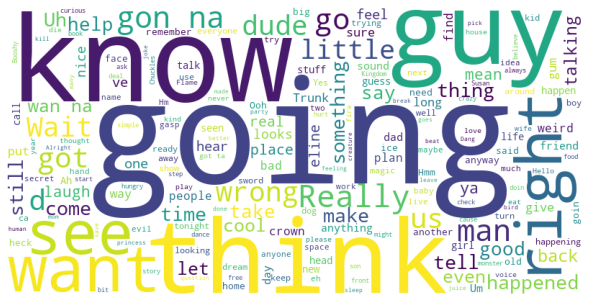

In [265]:
def get_stop_words():
    stop_words = set(stopwords.words('english'))
    custom_stop_words = {'Finn', '\'s', '\'m', 'n\'t', 'oh', 'yeah', '\'re', 'look', '\'ll', 'okay', 'hey', 'aah', 'heh', 'wow', 'huh', 'whoa'}
    stop_words.update(custom_stop_words)
    return stop_words

stop_words = get_stop_words()

def plot_emotion_wordcloud(df, emotion):
    emotion_text = get_emotion_text(df, emotion)
    origins = get_origins()
    for origin in origins:
        emotion_text = emotion_text.replace(origin, '')
    words = nltk.word_tokenize(emotion_text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    text = ' '.join(filtered_words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

plot_emotion_wordcloud(lines_df, 'curiosity')

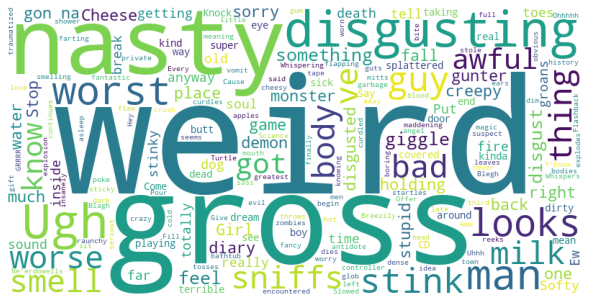

In [266]:
plot_emotion_wordcloud(lines_df, 'disgust')

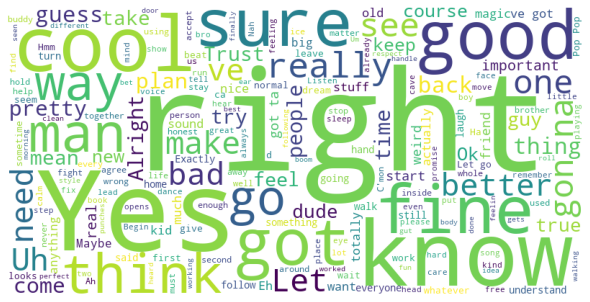

In [267]:
plot_emotion_wordcloud(lines_df, 'approval')

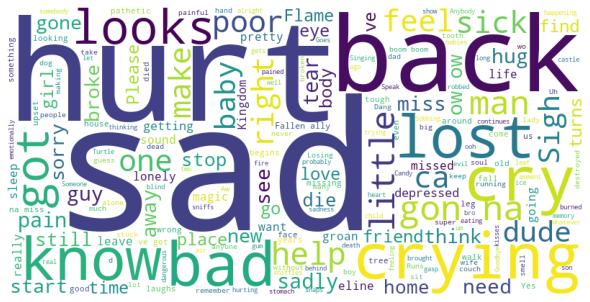

In [268]:
plot_emotion_wordcloud(lines_df, 'sadness')

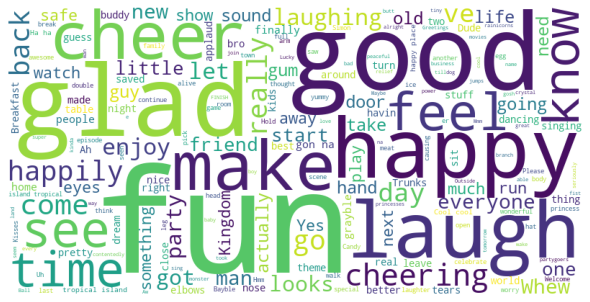

In [275]:
plot_emotion_wordcloud(lines_df, 'joy')

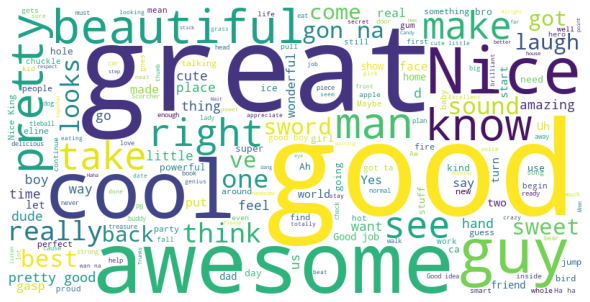

In [269]:
plot_emotion_wordcloud(lines_df, 'admiration')

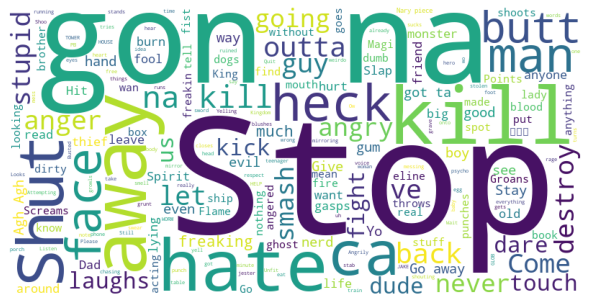

In [270]:
plot_emotion_wordcloud(lines_df, 'anger')

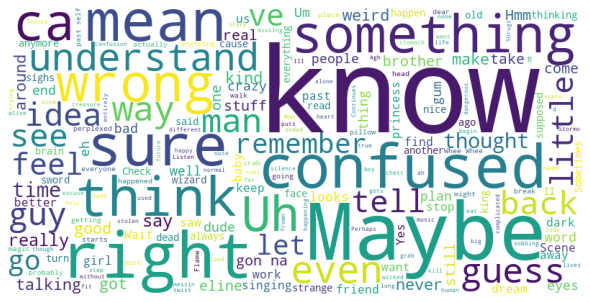

In [271]:
plot_emotion_wordcloud(lines_df, 'confusion')

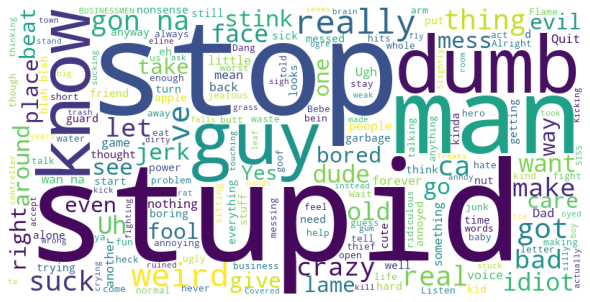

In [272]:
plot_emotion_wordcloud(lines_df, 'annoyance')

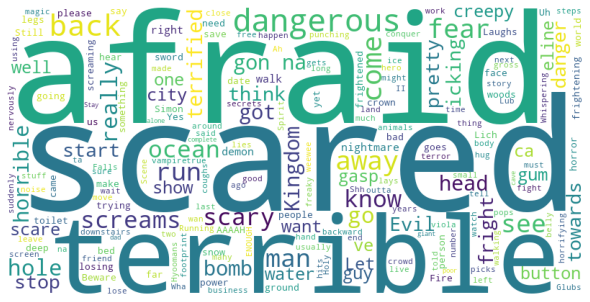

In [273]:
plot_emotion_wordcloud(lines_df, 'fear')

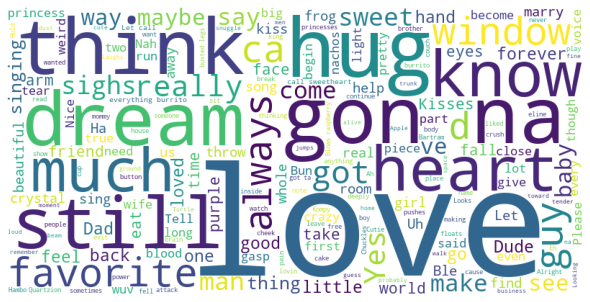

In [274]:
plot_emotion_wordcloud(lines_df, 'love')

In [194]:
writers = lines_df.explode('writers')['writers'].unique()
directors = lines_df.explode('directors')['directors'].unique()

In [206]:
writers_df = pd.DataFrame(columns=(['writer'] + labels))

for writer in writers:
    data = {emotion: 0 for emotion in labels}
    data['writer'] = writer

    filtered_rows = lines_df[lines_df['writers'].apply(lambda writers: writer in writers)].reset_index()
    for i in range(len(filtered_rows)):
        emotion = filtered_rows.iloc[i]['sentiment']
        if emotion != 'neutral':
            data[emotion] += 1
    new_data = pd.DataFrame([data])
    writers_df = pd.concat([writers_df, new_data], ignore_index=True)
writers_df[labels] = writers_df[labels].div(writers_df[labels].sum(axis=1), axis=0)
writers_df.sample(3)

,writer,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,gratitude,joy,love,nervousness,optimism,pride,realization,remorse,sadness,surprise
13,Rebecca Sugar,0.109453,0.072139,0.04602,0.027363,0.083333,0.058458,0.027363,0.169154,0.022388,...,0.032338,0.031095,0.034826,0.001244,0.00995,0.0,0.004975,0.032338,0.049751,0.031095
5,Armen Mirzaian,0.097561,0.04878,0.04878,0.060976,0.097561,0.097561,0.02439,0.097561,0.0,...,0.02439,0.036585,0.012195,0.0,0.012195,0.0,0.012195,0.012195,0.060976,0.060976
19,Natasha Allegri,0.125,0.075,0.0,0.025,0.075,0.05,0.025,0.175,0.025,...,0.025,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.1,0.05


In [298]:
def plot_graphic_writers(df, writer):
    df = df[df['writer'] == writer]

    df_mean_scaled = df[labels].mean(axis=0) * 100

    df_plot = pd.DataFrame({'Emotion': df_mean_scaled.index, 'Mean Value': df_mean_scaled.values})
    df_plot = df_plot.sort_values(by='Mean Value', ascending=False).iloc[:10]
    # Criar um histograma
    fig = px.bar(df_plot, x='Emotion', y='Mean Value',
                title=f'Proporção (%) de emoções em episódios escritos por {writer}',
                labels={'Mean Value': 'Porcentagem', 'Emotion': 'Emoção'},
                category_orders={'Emotion': df_plot['Emotion']})

    fig.update_layout(
        title_font=dict(size=24),  # Ajustar o tamanho da fonte do título
        xaxis_title_font=dict(size=18),  # Ajustar o tamanho da fonte do rótulo do eixo x
        yaxis_title_font=dict(size=18),  # Ajustar o tamanho da fonte do rótulo do eixo y
        xaxis=dict(tickfont=dict(size=18)),  # Ajustar o tamanho da fonte dos rótulos do eixo x
    )

    # Exibir o gráfico
    fig.show()

In [308]:
int_labels = ['curiosity', 'admiration', 'approval', 'amusement', 'excitement', 'caring', 'sadness', 'fear', 'joy', 'anger']
writers = ['Pendleton Ward', 'Rebecca Sugar', 'Armen Mirzaian', 'J. G. Quintel']


def plot_emotion_means(df, writers, emotions):
    df_filtered = df[df['writer'].isin(writers)][['writer'] + emotions]

    df_mean = (df_filtered.groupby('writer').mean() * 100).reset_index()

    df_melted = pd.melt(df_mean, id_vars='writer', value_vars=emotions, var_name='emotion', value_name='value')

    fig = px.bar(df_melted, x='emotion', y='value', color='writer',
                 title='Proporção (%) média de emoções por roteirista',
                 labels={'value': 'Média', 'emotion': 'Emoção'},
                 color_discrete_sequence=px.colors.qualitative.Set1,
                 barmode='group')

    fig.update_layout(
        title_font=dict(size=24),
        xaxis_title_font=dict(size=18),
        yaxis_title_font=dict(size=18),
        xaxis=dict(tickfont=dict(size=18)),
    )

    fig.show()

plot_emotion_means(writers_df, writers, int_labels)


In [301]:
writers_df

,writer,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,gratitude,joy,love,nervousness,optimism,pride,realization,remorse,sadness,surprise
0,Pendleton Ward,0.113503,0.084149,0.031311,0.033268,0.084149,0.056751,0.039139,0.170254,0.02544,...,0.035225,0.04501,0.02544,0.001957,0.001957,0.0,0.007828,0.023483,0.04501,0.023483
1,Adam Muto,0.115625,0.073958,0.038542,0.0375,0.085417,0.067708,0.022917,0.176042,0.016667,...,0.034375,0.035417,0.021875,0.002083,0.011458,0.0,0.004167,0.020833,0.0375,0.025
2,Bert Youn,0.088235,0.066845,0.045455,0.034759,0.07754,0.05615,0.032086,0.163102,0.018717,...,0.048128,0.025401,0.042781,0.0,0.005348,0.0,0.008021,0.013369,0.048128,0.036096
3,Sean Jimenez,0.105469,0.058594,0.046875,0.039062,0.105469,0.0625,0.027344,0.132812,0.023438,...,0.078125,0.019531,0.015625,0.0,0.011719,0.0,0.003906,0.007812,0.046875,0.035156
4,Luther McLaurin,0.099379,0.099379,0.037267,0.037267,0.093168,0.074534,0.031056,0.130435,0.0,...,0.018634,0.031056,0.018634,0.0,0.006211,0.0,0.012422,0.024845,0.049689,0.037267
5,Armen Mirzaian,0.097561,0.04878,0.04878,0.060976,0.097561,0.097561,0.02439,0.097561,0.0,...,0.02439,0.036585,0.012195,0.0,0.012195,0.0,0.012195,0.012195,0.060976,0.060976
6,Kent Osborne,0.119832,0.077085,0.016819,0.022425,0.094604,0.053259,0.028732,0.20042,0.023826,...,0.030133,0.023826,0.031535,0.003504,0.007008,0.0,0.010512,0.030133,0.035039,0.029432
7,J. G. Quintel,0.106667,0.093333,0.026667,0.026667,0.133333,0.106667,0.013333,0.053333,0.0,...,0.013333,0.04,0.0,0.0,0.013333,0.0,0.0,0.013333,0.013333,0.013333
8,Cole Sanchez,0.096974,0.079907,0.032583,0.025601,0.093095,0.06827,0.027929,0.155159,0.016292,...,0.032583,0.02948,0.03879,0.001552,0.01474,0.0,0.007758,0.034911,0.034911,0.025601
9,Elizabeth Ito,0.04878,0.097561,0.02439,0.04878,0.121951,0.097561,0.0,0.097561,0.02439,...,0.073171,0.0,0.02439,0.02439,0.073171,0.0,0.02439,0.0,0.04878,0.04878


In [299]:
plot_graphic_writers(writers_df, 'Rebecca Sugar')

In [283]:
plot_graphic_writers(writers_df, 'Pendleton Ward')

In [300]:
for writer in writers:
    print(writer)
    plot_graphic_writers(writers_df, writer)

Pendleton Ward


Adam Muto


Bert Youn


Sean Jimenez


Luther McLaurin


Armen Mirzaian


Kent Osborne


J. G. Quintel


Cole Sanchez


Elizabeth Ito


Tom Herpich


Niki Yang


Ako Castuera


Rebecca Sugar


Somvilay Xayaphone


Benton Connor


Jesse Moynihan


["Tom Herpich", "Steve Wolfhard", "Somvilay Xayaphone", "Seo Kim", "Aleks Sennwald", "Hanna K. Nystr\u00f6m", "Sam Alden", "Graham Falk"]


["Kent Osborne", "Somvilay Xayaphone"]


Natasha Allegri


Skyler Page Cole Sanchez


Skyler Page


Steve Wolfhard


Michael DeForge


Luke Pearson


Seo Kim


Andy Ristaino


Graham Falk


["Tom Herpich", "Steve Wolfhard"]


Derek Ballard


Masaaki Yuasa


Madéleine Flores


Jillian Tamaki


Brandon Graham


Kris Mukai


Lyle Partridge


Hanna K. Nyström


Sam Alden


Kirsten Lepore


Andres Salaff


Aleks Sennwald


Laura Knetzger


Polly Guo


Patrick McHale


In [231]:
def get_title(row, df=df):
    season = row['season_number']
    episode = row['episode_number']
    title = df[(df['season_number'] == season) & (df['episode_number'] == episode)].iloc[0]['title']

    return title

episode_sentiments_df['title'] = episode_sentiments_df.apply(get_title, axis=1)

In [278]:
def get_n_highest(emotion, n, df):
    n_highest = []
    bigger_indexes = df[emotion].nlargest(n).index
    bigger_values = df.loc[bigger_indexes]
    for i in range(n):
        episode = {}
        row = bigger_values.iloc[i]
        episode['season'] = row['season_number']
        episode['episode'] = row['episode_number']
        episode['title'] = row['title']
        episode['proportion'] = row[emotion]
        n_highest.append(episode)
    return n_highest

for emotion in labels:
    n_highest = get_n_highest(emotion, 3, episode_sentiments_df)
    
    print(f"Episódios com maior proporção de {emotion}:")
    for ep in n_highest:
        print(f"S{ep['season']}E{ep['episode']}: {ep['title']} ({round((ep['proportion'] * 100), 2)})")
    print()

Episódios com maior proporção de admiration:
S6E26: Gold Stars (29.09)
S6E16: Joshua and Margaret Investigations (25.0)
S6E41: On the Lam (25.0)

Episódios com maior proporção de amusement:
S6E5: Sad Face (32.26)
S2E7: Power Animal (30.95)
S10E9: Blenanas (22.81)

Episódios com maior proporção de anger:
S3E4: Hitman (14.29)
S8E7: Normal Man (13.89)
S7E7: Everything Stays (13.33)

Episódios com maior proporção de annoyance:
S6E41: On the Lam (25.0)
S7E10: May I Come In? (10.81)
S1E21: Donny (9.68)

Episódios com maior proporção de approval:
S3E22: Paper Pete (31.25)
S5E50: Lemonhope Part 1 (26.32)
S7E19: Blank-Eyed Girl (25.0)

Episódios com maior proporção de caring:
S7E7: Everything Stays (20.0)
S2E21: Belly of the Beast (17.65)
S8E13: Reboot (17.02)

Episódios com maior proporção de confusion:
S9E10: All the Little People (16.67)
S8E3: Beyond the Grotto (15.25)
S6E19: Is That You? (14.81)

Episódios com maior proporção de curiosity:
S8E17: High Strangeness (100.0)
S7E21: King's Ranso

In [254]:
def get_n_highest_character(emotion, n, df):
    n_highest = []
    bigger_indexes = df[emotion].nlargest(n).index
    bigger_values = df.loc[bigger_indexes]
    for i in range(n):
        character = {}
        row = bigger_values.iloc[i]
        character['name'] = row['character']
        character['proportion'] = row[emotion]
        n_highest.append(character)
    return n_highest

for emotion in labels:
    n_highest = get_n_highest_character(emotion, 3, new_characters_df)
    
    print(f"Personagens com maior proporção de {emotion}:")
    for char in n_highest:
        print(f"{char['name']}: {round((char['proportion'] * 100), 2)}")
    print()

Personagens com maior proporção de admiration:
Cream Puff Gentleman: 100.0
Trami: 66.67
Lamp: 50.0

Personagens com maior proporção de amusement:
Sir Slicer: 66.67
The Lich: 50.0
Head Clown Nurse: 42.86

Personagens com maior proporção de anger:
Forest Cyclops: 60.0
Cyclops: 50.0
Georgy: 33.33

Personagens com maior proporção de annoyance:
Big Destiny: 40.0
Hierophant: 33.33
Raccoon: 33.33

Personagens com maior proporção de approval:
Bounce House Princess: 100.0
Jaybird: 100.0
Head Marauder: 60.0

Personagens com maior proporção de caring:
Guardian Angel: 66.67
Mother: 66.67
King Worm: 50.0

Personagens com maior proporção de confusion:
Gork: 28.57
Roy: 25.0
Tromo: 25.0

Personagens com maior proporção de curiosity:
the Spirit of the Forest: 85.71
Banana Guard Leader: 75.0
Grob Gob Glob Grod: 66.67

Personagens com maior proporção de desire:
Blargetha: 50.0
The Lich: 50.0
Tonya: 50.0

Personagens com maior proporção de disappointment:
King Worm: 50.0
Grand Master Wizard: 20.0
Ice Quee

In [251]:
chars = ['Clone James', 'Audience', 'Penguin', 'Bush', 'Nightosphere Jailer', 'Jalapeño pepper', 'Unknown', 'Jake [Fake Finn]', 'Banana Guard #2', ]
new_characters_df = characters_df[~characters_df['character'].isin(chars)]

In [279]:
new_characters_df[new_characters_df['character'] == "Magic Man"]

,character,text,lines_amt,log_lines_amt,sentiments,admiration,amusement,anger,annoyance,approval,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
617,Magic Man,[[Magic Man is down on one knee and starts whi...,20,3.044522,"[neutral, neutral, neutral, joy, neutral, neut...",0.0,0.222222,0.0,0.0,0.222222,...,0.111111,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
